In [1]:
# import libraries
import pandas as pd
import numpy as np
from sodapy import Socrata

In [2]:
data_url = 'data.cityofnewyork.us'

In [3]:
data_set = 'hg8x-zxpr'

In [4]:
app_token = '3T4E27rJDweWSnY03BDvCX8sn'

In [5]:
nyc_open_data_client = Socrata(data_url, app_token, timeout = 200)
print(f"nyc open data client name is: {nyc_open_data_client}")
print(f"nyc open data client data type is: {type(nyc_open_data_client)}")

nyc open data client name is: <sodapy.socrata.Socrata object at 0x00000166BD2B3790>
nyc open data client data type is: <class 'sodapy.socrata.Socrata'>


In [6]:
total_record_count = nyc_open_data_client.get(data_set, select = "COUNT(*)")
print(f"total records in {data_set}: {total_record_count[0]['COUNT']}")

total records in hg8x-zxpr: 5798


In [7]:
def extract_socrata_data(chunk_size = 2500,
                         data_set = data_set,
                         where = None):
    
    # measure time this function takes
    import time
    start_time = time.time()
    
    # get total number or records
    if where == None:
        total_records = int(nyc_open_data_client.get(data_set,
                                                     select= "COUNT(*)")[0]["COUNT"])
    else:
        total_records = int(nyc_open_data_client.get(data_set,
                                                     where = where,
                                                     select= "COUNT(*)")[0]["COUNT"])
    
    # start at 0, empty list for results
    start = 0                   
    results = []                

    while True:

        if where == None:
            # fetch the set of records starting at 'start'
            results.extend(nyc_open_data_client.get(data_set,
                                                    offset = start,
                                                    limit = chunk_size))
            
        elif where != None:
            results.extend(nyc_open_data_client.get(data_set,
                                                    where = where,
                                                    offset = start,
                                                    limit = chunk_size))
        # update the starting record number
        start = start + chunk_size

        # if we have fetched all of the records (we have reached total_records), exit loop
        if (start > total_records):
            break

    # convert the list into a pandas data frame
    data = pd.DataFrame.from_records(results)

    end_time = time.time()
    print(f"function took {round(end_time - start_time, 1)} seconds")

    print(f"the shape of your dataframe is: {data.shape}")
    return data

In [8]:
data = extract_socrata_data(chunk_size = 5798,
                         data_set = data_set)

function took 0.9 seconds
the shape of your dataframe is: (5798, 41)


In [9]:
data.columns

Index(['project_id', 'project_name', 'project_start_date', 'building_id',
       'house_number', 'street_name', 'borough', 'postcode', 'bbl',
       'community_board', 'council_district', 'census_tract',
       'neighborhood_tabulation_area', 'latitude', 'longitude',
       'latitude_internal', 'longitude_internal',
       'reporting_construction_type', 'extended_affordability_status',
       'prevailing_wage_status', 'extremely_low_income_units',
       'very_low_income_units', 'low_income_units', 'moderate_income_units',
       'middle_income_units', 'other_income_units', 'studio_units',
       '_1_br_units', '_2_br_units', '_3_br_units', '_4_br_units',
       '_5_br_units', '_6_br_units', 'unknown_br_units',
       'counted_rental_units', 'counted_homeownership_units',
       'all_counted_units', 'total_units', 'project_completion_date',
       'building_completion_date', 'bin'],
      dtype='object')

In [10]:
# create and run a function to ceate data profiling dataframe

def create_data_profiling_df(data):
    
    # create an empty dataframe to gather information about each column
    data_profiling_df = pd.DataFrame(columns = ["column_name",
                                                "column_type",
                                                "unique_values",
                                                "duplicate_values",
                                                "null_values",
                                                "non_null_values"])

    # loop through each column to add rows to the data_profiling_df dataframe
    for column in data.columns:

        info_dict = {}

        try:
            info_dict["column_name"] = column
            info_dict["column_type"] = data[column].dtypes
            info_dict["unique_values"] = len(data[column].unique())
            info_dict["duplicate_values"] = data[column].count() - len(data[column].dropna().unique())
            info_dict["null_values"] = data[column].isna().sum()
            info_dict["non_null_values"] = data[column].count()

        except:
            print(f"unable to read column: {column}, you may want to drop this column")

        data_profiling_df = data_profiling_df.append(info_dict, ignore_index=True)

    data_profiling_df.sort_values(by = ['unique_values', "non_null_values"],
                                  ascending = [False, False],
                                  inplace=True)
    
    return data_profiling_df

In [11]:
data_profiling_df = create_data_profiling_df(data = data)

In [12]:
data_profiling_df

,column_name,column_type,unique_values,duplicate_values,null_values,non_null_values
3,building_id,object,4663,47,1089,4709
13,latitude,object,4469,174,1156,4642
14,longitude,object,4463,180,1156,4642
8,bbl,object,3854,699,1246,4552
16,longitude_internal,object,3806,740,1253,4545
15,latitude_internal,object,3494,1052,1253,4545
0,project_id,object,3185,2613,0,5798
40,bin,object,2794,73,2932,2866
4,house_number,object,2259,3539,0,5798
1,project_name,object,2097,3701,0,5798


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5798 entries, 0 to 5797
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   project_id                     5798 non-null   object
 1   project_name                   5798 non-null   object
 2   project_start_date             5798 non-null   object
 3   building_id                    4709 non-null   object
 4   house_number                   5798 non-null   object
 5   street_name                    5798 non-null   object
 6   borough                        5798 non-null   object
 7   postcode                       4642 non-null   object
 8   bbl                            4552 non-null   object
 9   community_board                5798 non-null   object
 10  council_district               5783 non-null   object
 11  census_tract                   4648 non-null   object
 12  neighborhood_tabulation_area   4648 non-null   object
 13  lat

In [14]:
#turn counts into numbers
data["extremely_low_income_units"] = data["extremely_low_income_units"].astype(float)
data["very_low_income_units"] = data["very_low_income_units"].astype(float)
data["low_income_units"] = data["low_income_units"].astype(float)
data["moderate_income_units"] = data["moderate_income_units"].astype(float)
data["middle_income_units"] = data["middle_income_units"].astype(float)
data["other_income_units"] = data["other_income_units"].astype(float)
data["studio_units"] = data["studio_units"].astype(float)
data["_1_br_units"] = data["_1_br_units"].astype(float)
data["_2_br_units"] = data["_2_br_units"].astype(float)
data["_3_br_units"] = data["_3_br_units"].astype(float)
data["_4_br_units"] = data["_4_br_units"].astype(float)
data["_5_br_units"] = data["_5_br_units"].astype(float)
data["_6_br_units"] = data["_6_br_units"].astype(float)
data["unknown_br_units"] = data["unknown_br_units"].astype(float)
data["counted_rental_units"] = data["counted_rental_units"].astype(float)
data["counted_homeownership_units"] = data["counted_homeownership_units"].astype(float)
data["all_counted_units"] = data["all_counted_units"].astype(float)
data["total_units"] = data["total_units"].astype(float)

In [15]:
#convert all date string objects into date objects
data["project_start_date"] = data["project_start_date"].astype('datetime64[ns]')
data["building_completion_date"] = data["building_completion_date"].astype('datetime64[ns]')
data["project_completion_date"] = data["project_completion_date"].astype('datetime64[ns]')

In [16]:
print(f"number of duplicate rows: {len(data[data.duplicated()])}")

number of duplicate rows: 0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5798 entries, 0 to 5797
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   project_id                     5798 non-null   object        
 1   project_name                   5798 non-null   object        
 2   project_start_date             5798 non-null   datetime64[ns]
 3   building_id                    4709 non-null   object        
 4   house_number                   5798 non-null   object        
 5   street_name                    5798 non-null   object        
 6   borough                        5798 non-null   object        
 7   postcode                       4642 non-null   object        
 8   bbl                            4552 non-null   object        
 9   community_board                5798 non-null   object        
 10  council_district               5783 non-null   object        
 11  census_tract     

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

[Text(0.5, 1.0, 'Total units by Borough')]

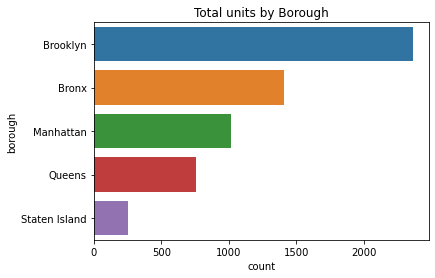

In [31]:
sns.countplot(y=data.borough).set(title='Total units by Borough')

[Text(0.5, 1.0, 'Type of construction by Borough')]

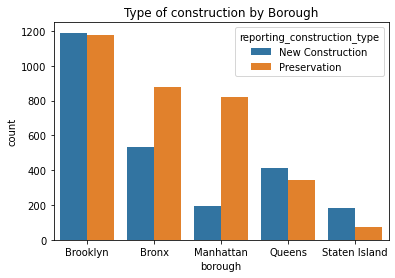

In [30]:
sns.countplot(x="borough", data=data, hue="reporting_construction_type").set(title='Type of construction by Borough')

C:\Users\Diego\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


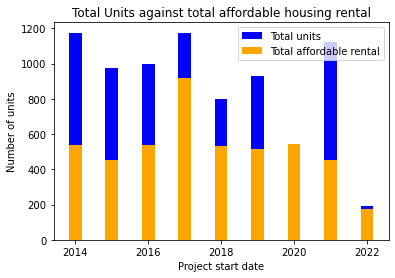

In [21]:
width = 0.35
fig, ax = plt.subplots()
ax.bar(data.project_start_date.dt.year, data.total_units, width, color="blue")
ax.bar(data.project_start_date.dt.year, data.counted_rental_units, width, color="orange")
ax.set_xlabel("Project start date")
ax.set_ylabel("Number of units")
ax.set_title("Total Units against total affordable housing rental")
ax.legend(["Total units", "Total affordable rental"])
plt.show()

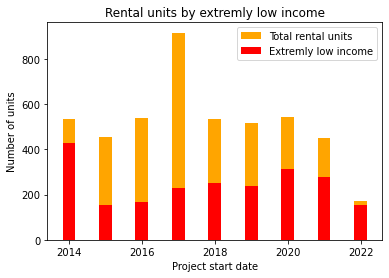

In [22]:
width = 0.35
fig, ax = plt.subplots()
ax.bar(data.project_start_date.dt.year, data.counted_rental_units, width, color="orange")
ax.bar(data.project_start_date.dt.year, data.extremely_low_income_units, width, color="red")
ax.set_ylabel("Number of units")
ax.set_xlabel("Project start date")
ax.set_title("Rental units by extremly low income")
ax.legend(["Total rental units", "Extremly low income"])
plt.show()

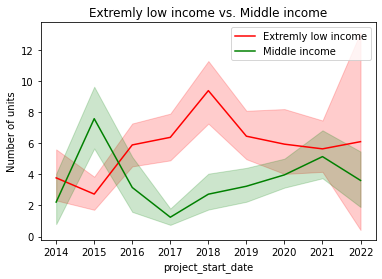

In [23]:
fig, ax = plt.subplots()
ax = sns.lineplot(x=data.project_start_date.dt.year, y=data.extremely_low_income_units, color="red")
ax = sns.lineplot(x=data.project_start_date.dt.year, y=data.middle_income_units, color="green")
ax.set_ylabel("Number of units")
ax.set_title("Extremly low income vs. Middle income")
ax.legend(["Extremly low income", "Middle income"])
plt.show()

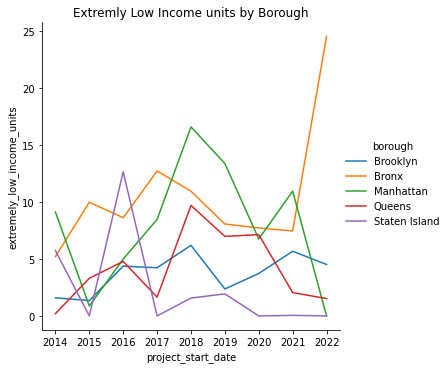

In [34]:
sns.relplot(x=data.project_start_date.dt.year, y=data.extremely_low_income_units, data=data, kind="line", style="borough", hue="borough", dashes=False, ci=None).set(title='Extremly Low Income units by Borough')

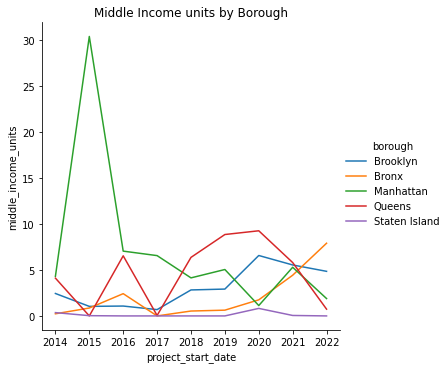

In [33]:
sns.relplot(x=data.project_start_date.dt.year, y=data.middle_income_units, data=data, kind="line", style="borough", hue="borough", dashes=False, ci=None).set(title='Middle Income units by Borough')